# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skojaku/applied-soft-comp/blob/master/notebooks/graph-neural-net.ipynb)


# Exercise M05: Graph Neural Networks

We can think of a convolution of an image from the perspective of networks.
In the convolution of an image, a pixel is convolved with its *neighbors*. We can regard each pixel as a node, and each node is connected to its neighboring nodes (pixels) that are involved in the convolution.

![](https://av-eks-lekhak.s3.amazonaws.com/media/__sized__/article_images/conv_graph-thumbnail_webp-600x300.webp)

Suppose that each node has a variable $x_i \in \mathbb{R}$, just like each pixel has a value in a grey image. Consider a network of $N$ such nodes. 

In this example, we use the karate club network and set $x$ by a random gaussian variable.

In [14]:
import igraph as ig
import numpy as np
from scipy import sparse
import matplotlib as mpl

G = ig.Graph.Famous("Zachary")
A = G.get_adjacency_sparse()

x = np.random.randn(G.vcount())



We define the *total variation* of ${\mathbf x}$ as the sum of the squared differences between connected nodes:

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 = {\bf x}^\top {\bf L} {\bf x},
$$

where ${\bf L}$ is the Laplacian matrix of the graph given by

$$
L_{ij} = \begin{cases}
-1 & \text{if } i \text{ and } j \text{ are connected} \\
k_i & \text{if } i = j \\
0 & \text{otherwise}
\end{cases}.
$$

and ${\bf x} = [x_1,x_2,\ldots, x_N]^\top$ is a column vector of feature variables.

In [2]:
# Compute the total variation of x by definition
J = 0
for i in range(G.vcount()):
  for j in range(G.vcount()):
    if A[i,j] != 0:
      J += (x[i] - x[j])**2
J = J / 2

# Compute the total variation of x by using the Laplacian matrix
deg = A.sum(axis = 1).A1
L = sparse.diags(deg) - A
J_by_laplacian = x.T @ L @ x

print(f"J: {J}, J_by_laplacian: {J_by_laplacian}")

J: 200.99553134088475, J_by_laplacian: 200.99553134088472


We decompose the total variation into high-frequency and low-frequency components by using the eigenvectors ${\bf u}_i$ and the eigenvalues $\lambda_i$ of the Laplacian matrix:

$$
J = \sum_{i=1}^N \lambda_i  {\bf x}^\top {\mathbf u}_i {\mathbf u}_i^\top {\bf x} = \sum_{i=1}^N \lambda_i  ||{\bf x}^\top {\mathbf u}_i||^2.
$$

The term $({\bf x}^\top {\mathbf u}_i)$ is a dot-product between the feature vector ${\bf x}$ and the eigenvector ${\mathbf u}_i$, measuring how much ${\bf x}$ aligns with ${\mathbf u}_i$, similar to Fourier coefficients with sinusoids. Each $||{\bf x}^\top {\mathbf u}_i||^2$ represents the ''strength'' of ${\bf x}$ with respect to ${\mathbf u}_i$, making the total variation $J$ a weighted sum of these strengths.

In [3]:
# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigvals, eigvecs = np.linalg.eigh(L.toarray())

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigvals)
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

strength = []
for i in range(len(eigvals)):
  strength.append(np.sum((x.T @ eigvecs[:,i])**2))

J_by_eig = np.sum(strength * eigvals)
print(f"J: {J}, J_by_eig: {J_by_eig}")

J: 200.99553134088475, J_by_eig: 200.9955313408847


And here is the "frequency" of each component in increasing order of eigenvalues (frequency).

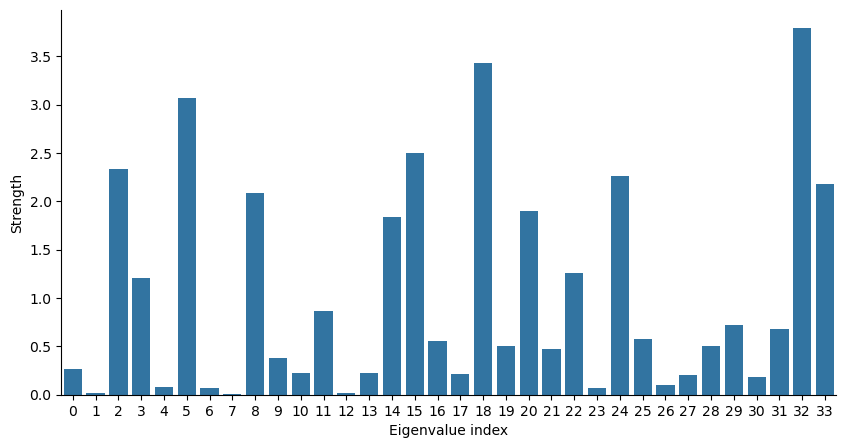

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength")
sns.despine()
plt.show()

The eigenvalues $\lambda_i$ are then multipled by the strength of the corresponding component, and the total is the total variation $J$.  

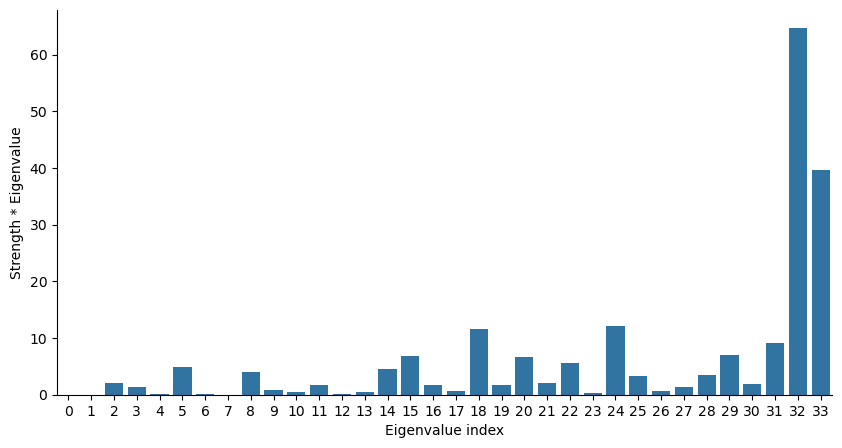

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength * eigvals)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength * Eigenvalue")
sns.despine()
plt.show()

Now, we can consider "eigenvals" as a filter that controls which frequency components pass through 😉. For example, if we want to keep the low-frequency components, we can set the high-frequency components to zero.

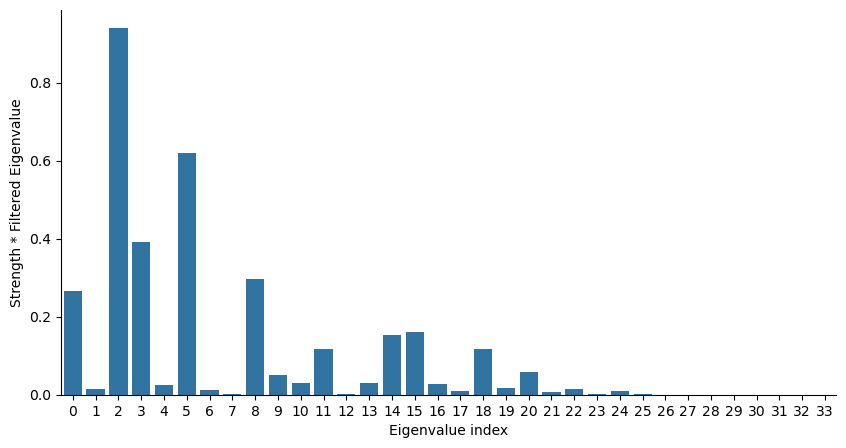

In [26]:
# Low pass filter #1
eigvals_filtered = eigvals.copy()
eigvals_filtered= 1.0 / (1 +eigvals_filtered) # low pass filter

# Low pass filter #2
eigvals_filtered = eigvals.copy()
eigvals_filtered[4:] = 0
eigvals_filtered[:4] = 1.0


# Low pass filter #3
eigvals_filtered = eigvals.copy()
eigvals_filtered = np.exp(-eigvals_filtered)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=range(len(eigvals)), y=strength * eigvals_filtered)

ax.set_xlabel("Eigenvalue index")

ax.set_ylabel("Strength * Filtered Eigenvalue")
sns.despine()
plt.show()

Using this filter, we reconstruct the Laplacian matrix.  



In [27]:
L_filtered = eigvecs @ np.diag(eigvals_filtered) @ eigvecs.T

<Axes: title={'center': 'Reconstructed Laplacian from filtered eigenvalues'}>

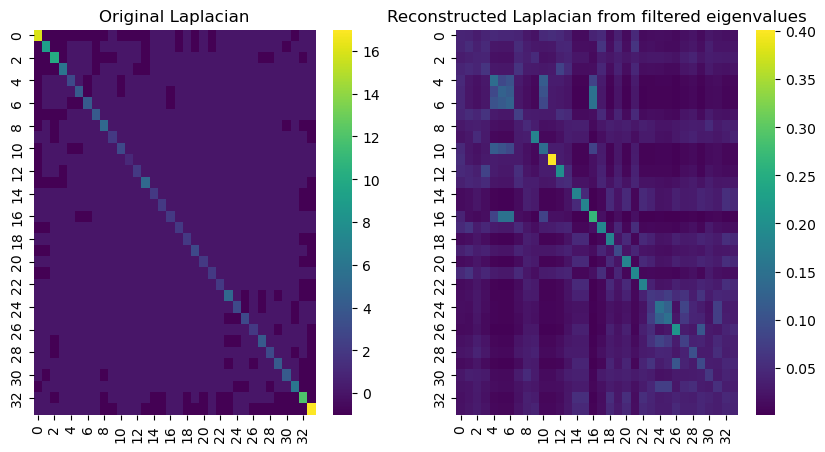

In [28]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Original Laplacian")
axes[1].set_title("Reconstructed Laplacian from filtered eigenvalues")
sns.heatmap(L.toarray(), cmap = 'viridis', ax=axes[0])
sns.heatmap(L_filtered, cmap = 'viridis', ax=axes[1])

We now have a new "convolution" matrix $L_{\text{filtered}}$ with which to generate a new feature vector ${\bf x}'$.

In [29]:
x_prime = L_filtered @ x

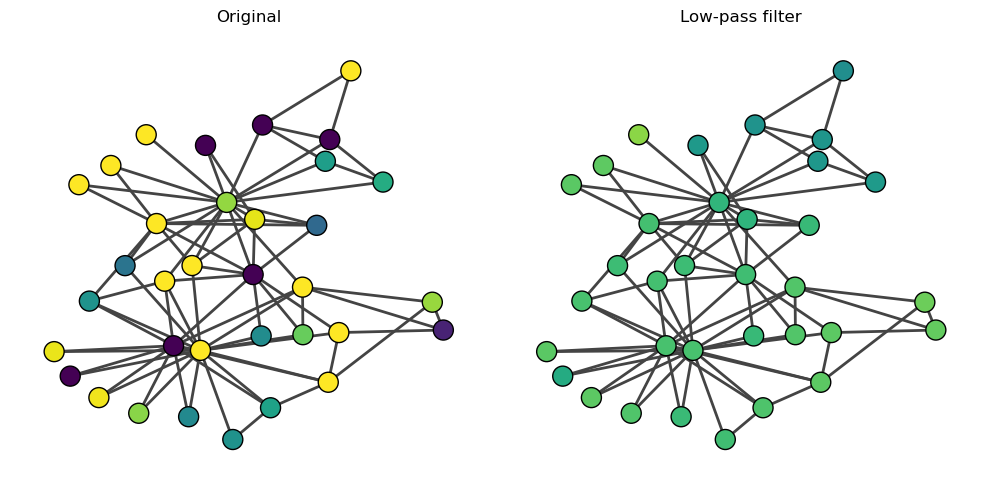

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), )
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.8)

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x_prime], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("Low-pass filter")

fig.tight_layout()

Observe that the values of the nodes are smoothed out, since the high-frequency components are suppressed.

### Exercise 2 🏋️:

Design your own filter to detect the high-frequency components of the graph. And apply the filter to:

1. Random gaussian variables 
2. Eigenvector centrality of the graph.

Then, compare the results with the original ones.

**Construct your own filter**

In [43]:
eigvals_filtered = eigvals.copy()

# Design your own filter here
alpha = 0.1
eigenvals_filtered =  alpha * eigvals_filtered / (1.0 + eigvals_filtered)

#eigenvals_filtered =  np.exp(eigenvals_filtered)
L_filtered = eigvecs @ np.diag(eigvals_filtered) @ eigvecs.T


**Apply the filter to random gaussian variables**

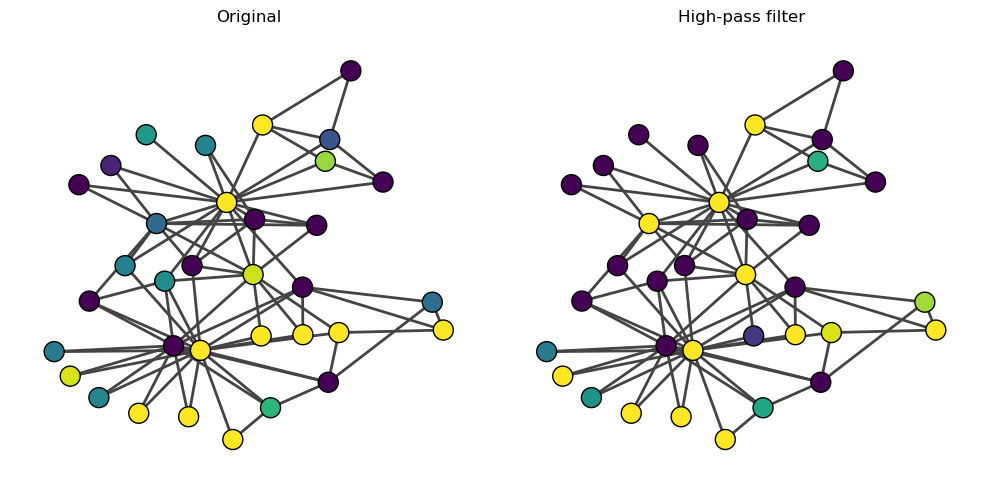

In [44]:
x = np.random.randn(G.vcount())
x_prime = L_filtered @ x

fig, axes = plt.subplots(1, 2, figsize=(10, 5), )
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.8)

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x_prime], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("High-pass filter")

fig.tight_layout()

**Apply the filter to eigenvector centrality**

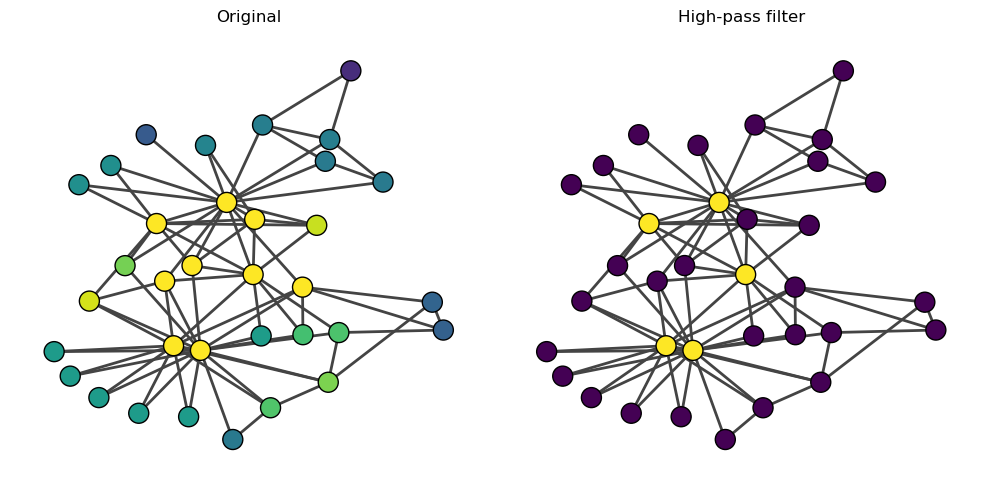

In [45]:
x = G.eigenvector_centrality()

x_prime = L_filtered @ x

fig, axes = plt.subplots(1, 2, figsize=(10, 5), )
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

ig.plot(G, vertex_color=[palette(norm(_x)) for _x in x_prime], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("High-pass filter")

fig.tight_layout()